<a href="https://colab.research.google.com/github/pranscript/neural_jupyter/blob/master/Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline                                               
%config InlineBackend.figure_format = 'retina'                   

import numpy as np
import torch

In [0]:
import matplotlib.pyplot as plt                                                  
from torchvision import datasets, transforms                       
from torch import nn                                                 
import torch.nn.functional as F                                   
from torch import optim 

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# 'download=true' downloads the dataset, 'train=true' creates dataset from training otherwise from test.
# dataloader provides an batch loading function for dataset. 'batch_size' set no. of samples per batch to load. 'Shuffle=true' shuffles data every epoch.
trainset = datasets.FashionMNIST('~/.pytorch/Fashion_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [0]:
input_size = 784                                                    
hidden_sizes1 = [256, 128]
hidden_sizes2 = [128, 64]
output_size = 10

In [16]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes1[0])),
                      ('relu1', nn.ReLU()),
                      ('drop1', nn.Dropout(p=0.2)),
                      ('fc2', nn.Linear(hidden_sizes1[0], hidden_sizes1[1])),
                      ('relu2', nn.ReLU()),
                      ('drop2', nn.Dropout(p=0.2)),
                      ('fc3', nn.Linear(hidden_sizes2[0], hidden_sizes2[1])),
                      ('relu3', nn.ReLU()),
                      ('drop3', nn.Dropout(p=0.2)),
                      ('output', nn.Linear(hidden_sizes2[1], output_size)),
                      ('logsoftmax', nn.LogSoftmax(dim=1))]))

criterion = nn.NLLLoss()      # negative log loss
optimizer = optim.Adam(model.parameters(), lr=0.003)
print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (drop3): Dropout(p=0.2, inplace=False)
  (output): Linear(in_features=64, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)


In [17]:
#images, labels = next(iter(trainloader))
train_losses, test_losses = [], []

epochs = 30
steps = 0

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        #print(f"Training loss: {running_loss/len(trainloader)}")
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
          model.eval()
          for images, labels in testloader:
            images = images.view(images.shape[0], -1)
            log_ps = model(images)
            test_loss += criterion(log_ps, labels)

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.603..  Test Loss: 0.489..  Test Accuracy: 0.824
Epoch: 2/30..  Training Loss: 0.481..  Test Loss: 0.441..  Test Accuracy: 0.843
Epoch: 3/30..  Training Loss: 0.454..  Test Loss: 0.437..  Test Accuracy: 0.839
Epoch: 4/30..  Training Loss: 0.430..  Test Loss: 0.420..  Test Accuracy: 0.848
Epoch: 5/30..  Training Loss: 0.417..  Test Loss: 0.404..  Test Accuracy: 0.851
Epoch: 6/30..  Training Loss: 0.420..  Test Loss: 0.412..  Test Accuracy: 0.856
Epoch: 7/30..  Training Loss: 0.401..  Test Loss: 0.434..  Test Accuracy: 0.849
Epoch: 8/30..  Training Loss: 0.403..  Test Loss: 0.407..  Test Accuracy: 0.857
Epoch: 9/30..  Training Loss: 0.388..  Test Loss: 0.375..  Test Accuracy: 0.869
Epoch: 10/30..  Training Loss: 0.392..  Test Loss: 0.373..  Test Accuracy: 0.868
Epoch: 11/30..  Training Loss: 0.385..  Test Loss: 0.379..  Test Accuracy: 0.863
Epoch: 12/30..  Training Loss: 0.381..  Test Loss: 0.384..  Test Accuracy: 0.868
Epoch: 13/30..  Training Loss: 0.380.

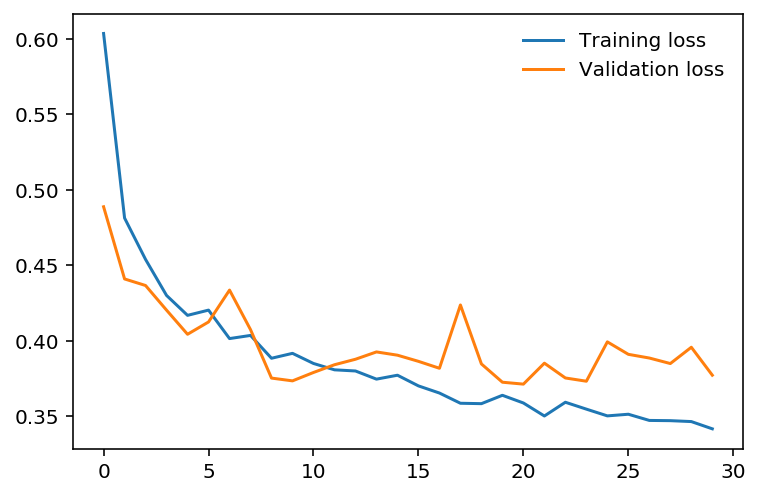

In [18]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

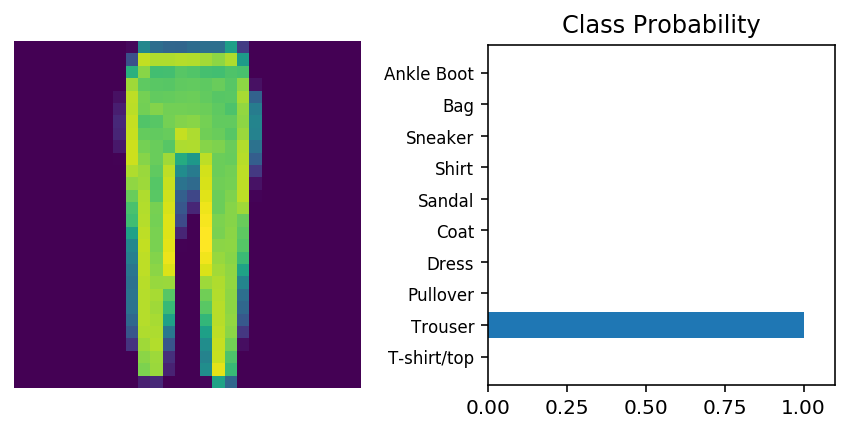

In [24]:
model.eval()
images, labels = next(iter(trainloader))
img = images[0].view(1, 784)

with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)
img = img.view(1, 28, 28)
ps = ps.data.numpy().squeeze()
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
ax1.axis('off')
ax2.barh(np.arange(10), ps)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()